# How to sample surrogate data

In this thesis we have define two types of surrogate date, the 'reconstruct and RTRBM' surrgate data and the
Poisson Mother Train (PMT) surrogate data.

import libraries

In [1]:
import os

os.getcwd()

'C:\\Users\\sebas\\RU\\intern\\notebooks\\Reconstructing RTRBM'

In [2]:
import torch
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from boltzmann_machines.cp_rtrbm import RTRBM
from boltzmann_machines.RBM import RBM
from utils.funcs import set_to_device

from utils.plots import plot_weights, raster_plot, plot_reconstruction_error, plot_rtrbm_reestimate_weights, hist_strongest_weights, plot_weights_log_distribution
from utils.moments_plot import infer_and_get_moments_plot
from utils.map_hidden_structure import MapHiddenStructure
#from utils.funcs import set_to_device

from data.rtrbm_data import get_rtrbm_data
from data.poisson_data import PoissonTimeShiftedData

# Reconstruct an RTRBM

The procedure behind reconstruct an RTRBM data is
* Initialize RTRBM with partially random weights
* Weights are initialized such that
    * Each hidden unit(HU) is most strongly connected to one population of visibles
    * HUs can also be less strongly connected to other populations
    * The norm of $W$ is roughly equal to negative norm $U$: $\sum_{i} W_{\mu i} \approx - \sum_{\mu'} U_{\mu' \mu}$ , such that we have a more dynamical hidden trace
* Use Gibbs samples from the RTRBM where the biases are zero and the weights are initialized with the partially random weights to construct a dataset
* Train another RTRBM on this dataset to confirm if the RTRBM is able to reconstruct the original RTRBM



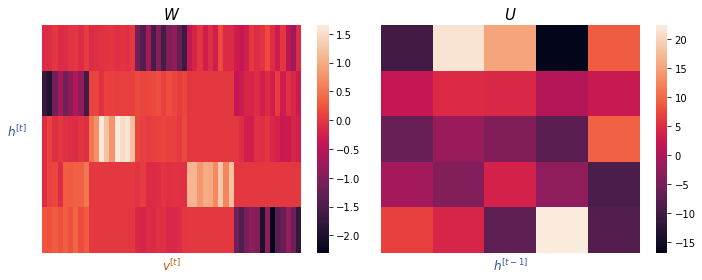

In [3]:
resample = False
dir_path = r'C:\Users\sebas\OneDrive\Intern\rtrbm_master'

n_batches = 300
N_H, N_V, T = 5, 20, 50

if resample:
    rtrbm_original, data, _ = get_rtrbm_data(N_H=N_H, N_V=N_V, T=T, n_batches=n_batches, pre_gibbs_k=100, gibbs_k=100, mode=1, show_figure=True)
else:
    rtrbm_original, data = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Paper\Surrogate_data\Reconstruct_RTRBM\rtrbm_original_&_data')
    idx_ = torch.randperm(N_H)
    plot_weights(rtrbm_original.W[idx_, :].cpu(), rtrbm_original.U[idx_, :].cpu())

#raster_plot(data[..., 0], figsize=(15, 4), title='Spiking pattern')

Now train an rtrbm on this dataset and compare the weights

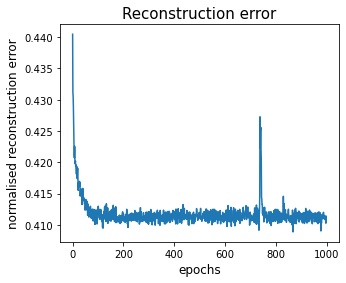

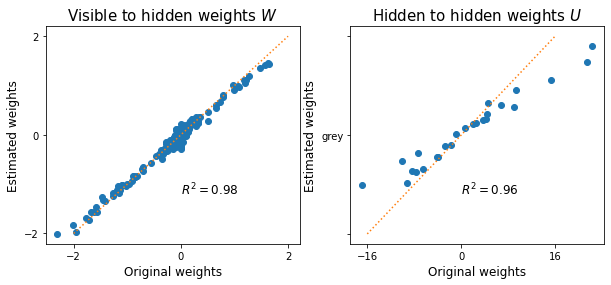

In [4]:
retrain = False

if retrain:
    rtrbm_reconstruct = RTRBM(data, N_H=N_H, device='cpu', no_bias=True, debug_mode=False)
    rtrbm_reconstruct.learn(n_epochs=1000, lr_schedule='linear_decay', batch_size=10, CDk=10, mom=0.9, wc=0.0002, min_lr=5e-4, max_lr=5e-3)
else:
    rtrbm_reconstruct = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Paper\Surrogate_data\Reconstruct_RTRBM\rtrbm_reconstruct')

plot_reconstruction_error(rtrbm_reconstruct.errors, figsize=(5, 4))
plot_rtrbm_reestimate_weights(rtrbm_original, rtrbm_reconstruct)

# Poisson mother train

The procedure behind PMT data is
* Define $n_{pop}$ different neuron populations
* Sample for each population a poisson mother train for a given random time-dependent firing rate
* Define spatial correlations within each population and define temporal correlations from population to population
* Let neurons in the same population have the same spike mother train
* Add or delete spikes according to spatial and temporal correlations across all neurons

In [ ]:
resample = True

if resample:
    data = poisson_data(n_batches=200, n_pop=5, n_per_pop=20, fr=.15, T=100, correlation=.8, snr=5)
else:
    ss, lr_decay, rt = 200, 0.9, 2
    path = r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Investigate lr\run 1'
    [rtrbm, W, U, errors] = torch.load( open(path + '/run 1/rtrbm_cosine_annealing_warm_restarts_ss'+str(ss)+'_lr_decay'+str(int(lr_decay*10))+'_n'+str(rt), 'rb'))
    data = rtrbm.V.detach().clone().to('cpu')
    #data = torch.load('')

raster_plot(data[..., 0], figsize=(15, 4), title='Spiking pattern')


  3%|▎         | 10/300 [01:27<41:34,  8.60s/it]

In [ ]:
if resample:
    rtrbm = RTRBM(data, N_H=N_H, device='cpu', no_bias=False, debug_mode=False)
    rtrbm.learn(n_epochs=300, lr_schedule='linear_decay', batch_size=10, CDk=15, mom=0.9, wc=0.0002, min_lr=5e-4, max_lr=5e-3)
    rbm = RTRBM(data, N_H=N_H, device='cpu', no_bias=False, debug_mode=False)
    rbm.learn(n_epochs=300, lr_schedule='linear_decay', batch_size=10, CDk=15, mom=0.9, wc=0.0002, min_lr=5e-4, max_lr=5e-3)
else:
    # rtrbm = torch.load('...')
    # rbm = torch.load('...')
    rtrbm.errors = errors
    set_to_device(rtrbm, 'cpu')

plot_reconstruction_error(rtrbm.errors, fs=12, title='Reconstruction error RTRBM')
# _, ax = plt.subplots(1, 2, figsize=(8, 5))
# plot_reconstruction_error(rtrbm.errors, ax=ax[0], fs=12, title='Reconstruction error RTRBM')
# plot_reconstruction_error(rbm.errors, ax=ax[1], fs=12, title='Reconstruction error RBM')


<AxesSubplot:title={'center':'$U$'}, xlabel='$h^{[t-1]}$', ylabel='$h^{[t]}$'>

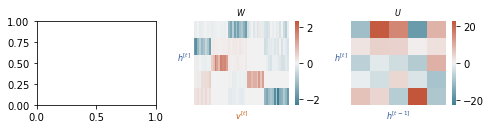

In [5]:
def figure_1a(W, U, figsize=(8.27, 11.69), fs=8):
    # full A4 = (8.27, 11.69) inch
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    maxi = max(abs(W.ravel()))
    cmap = sns.diverging_palette(220, 20, sep=1, n=1000, as_cmap=True)
    sns.heatmap(W, cmap=cmap, ax=axes[1], vmin=-maxi, vmax=maxi)
    axes[1].set_ylabel('$h^{[t]}$', color='#2F5597', fontsize=fs, rotation=0, labelpad=10)
    axes[1].set_xlabel('$v^{[t]}$', color='#C55A11', fontsize=fs)
    axes[1].set_title('$W$', fontsize=fs)
    # axes[0].tick_params(axis='both', which='major', labelsize=10)
    axes[1].xaxis.set_ticks([])
    axes[1].yaxis.set_ticks([])

    maxi = max(abs(U.ravel()))
    cmap = sns.diverging_palette(220, 20, sep=1, n=1000, as_cmap=True)
    sns.heatmap(U, cmap=cmap, ax=axes[2], vmin=-maxi, vmax=maxi)
    axes[2].set_ylabel('$h^{[t]}$', color='#2F5597', fontsize=fs, rotation=0, labelpad=10)
    axes[2].set_xlabel('$h^{[t-1]}$', color='#2F5597', fontsize=fs)
    axes[2].set_title('$U$', fontsize=fs)
    # axes[1].tick_params(axis='both', which='major', labelsize=10)
    axes[2].xaxis.set_ticks([])
    axes[2].yaxis.set_ticks([])
    plt.tight_layout()
    return plt.gca()

figure_1a(rtrbm_original.W[idx_, :], rtrbm_original.U[idx_, :], figsize=(0.83 * 8.27, 1.11*1.7165), fs=8)
#plt.savefig(r'C:\Users\sebas\RU\intern\Figures\weigths_fig1a.png', orientation = 'portrait', format = 'png', dpi=800)


<AxesSubplot:>

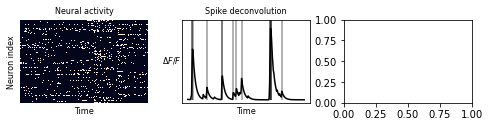

In [6]:
path2file = 'C:/Users/sebas/RU/intern/data/Chen_2018_subject_1/Deconvolved/subject_1_reconv_spikes.h5'
def figure_1b(path2file, figsize=(8.27, 11.69), fs=8):
    # full A4 = (8.27, 11.69) inch
    import h5py
    data_obj = h5py.File(path2file)
    # behavior = np.array(data_obj['Data']['behavior'])
    # coordinates = np.array(data_obj['Data']['coords'])
    df = np.array(data_obj['Data']['df'])
    spikes = np.array(data_obj['Data']['spikes'])
    # stimulus = np.array(data_obj['Data']['stimulus'])

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    idx = np.argsort(np.sum(spikes, 1))[::-1][:10000]
    idx = idx[np.random.permutation(len(idx))[:100]]
    idx[50]=403
    sns.heatmap(spikes[idx, 500:750]>0.15, ax=axes[0], cbar=False)
    axes[0].xaxis.set_ticks([])
    axes[0].yaxis.set_ticks([])
    axes[0].set_title('Neural activity', fontsize=fs)
    axes[0].set_ylabel('Neuron index', fontsize=fs)
    axes[0].set_xlabel('Time', fontsize=fs)


    idx = np.argsort(np.sum(spikes, 1))[::-1][403]#int(np.argmax(np.sum(spikes, 1)))
    df_sub = df[idx,500:750]
    #peaks = np.where((df_sub[1:-1] > df_sub[0:-2]) * (df_sub[1:-1] > df_sub[2:]))[0] + 1
    peaks = np.where( (spikes[idx, 500:750] > 0.5) == 1)
    axes[1].plot(df_sub, 'k')
    axes[1].set_ylim([-0.3, 8])
    axes[1].vlines(peaks, 0, 8, colors=(0, 0, 0, 0.4))
    axes[1].xaxis.set_ticks([])
    axes[1].yaxis.set_ticks([])
    axes[1].set_title('Spike deconvolution', fontsize=fs)
    axes[1].set_ylabel('$ \Delta F/F$', fontsize=fs, rotation=0, labelpad=20)
    axes[1].yaxis.set_label_coords(-0.08, 0.45)
    axes[1].set_xlabel('Time', fontsize=fs)

    plt.tight_layout()
    return plt.gca()
figure_1b(path2file, figsize=(0.83 * 8.27, 1.09*1.7165), fs=8)
#plt.savefig(r'C:\Users\sebas\RU\intern\Figures\Spike_deconvolve_fig2a.png', orientation = 'portrait', format = 'png', dpi=800)

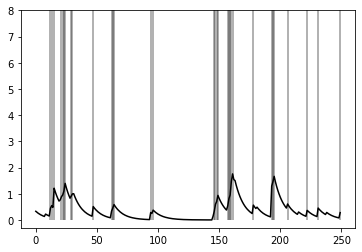

In [9]:
import h5py
data_obj = h5py.File(path2file)
# behavior = np.array(data_obj['Data']['behavior'])
# coordinates = np.array(data_obj['Data']['coords'])
df = np.array(data_obj['Data']['df'])
spikes = np.array(data_obj['Data']['spikes'])
# stimulus = np.array(data_obj['Data']['stimulus'])
idx = np.argsort(np.sum(spikes, 1))[::-1][400]#int(np.argmax(np.sum(spikes, 1)))
df_sub = df[idx,500:750]
#peaks = np.where((df_sub[1:-1] > df_sub[0:-2]) * (df_sub[1:-1] > df_sub[2:]))[0] + 1
peaks = np.where( (spikes[idx, 500:750] > 0.15) == 1)
plt.plot(df_sub, 'k')
plt.ylim([-0.3, 8])
plt.vlines(peaks, 0, 8, colors=(0, 0, 0, 0.4))

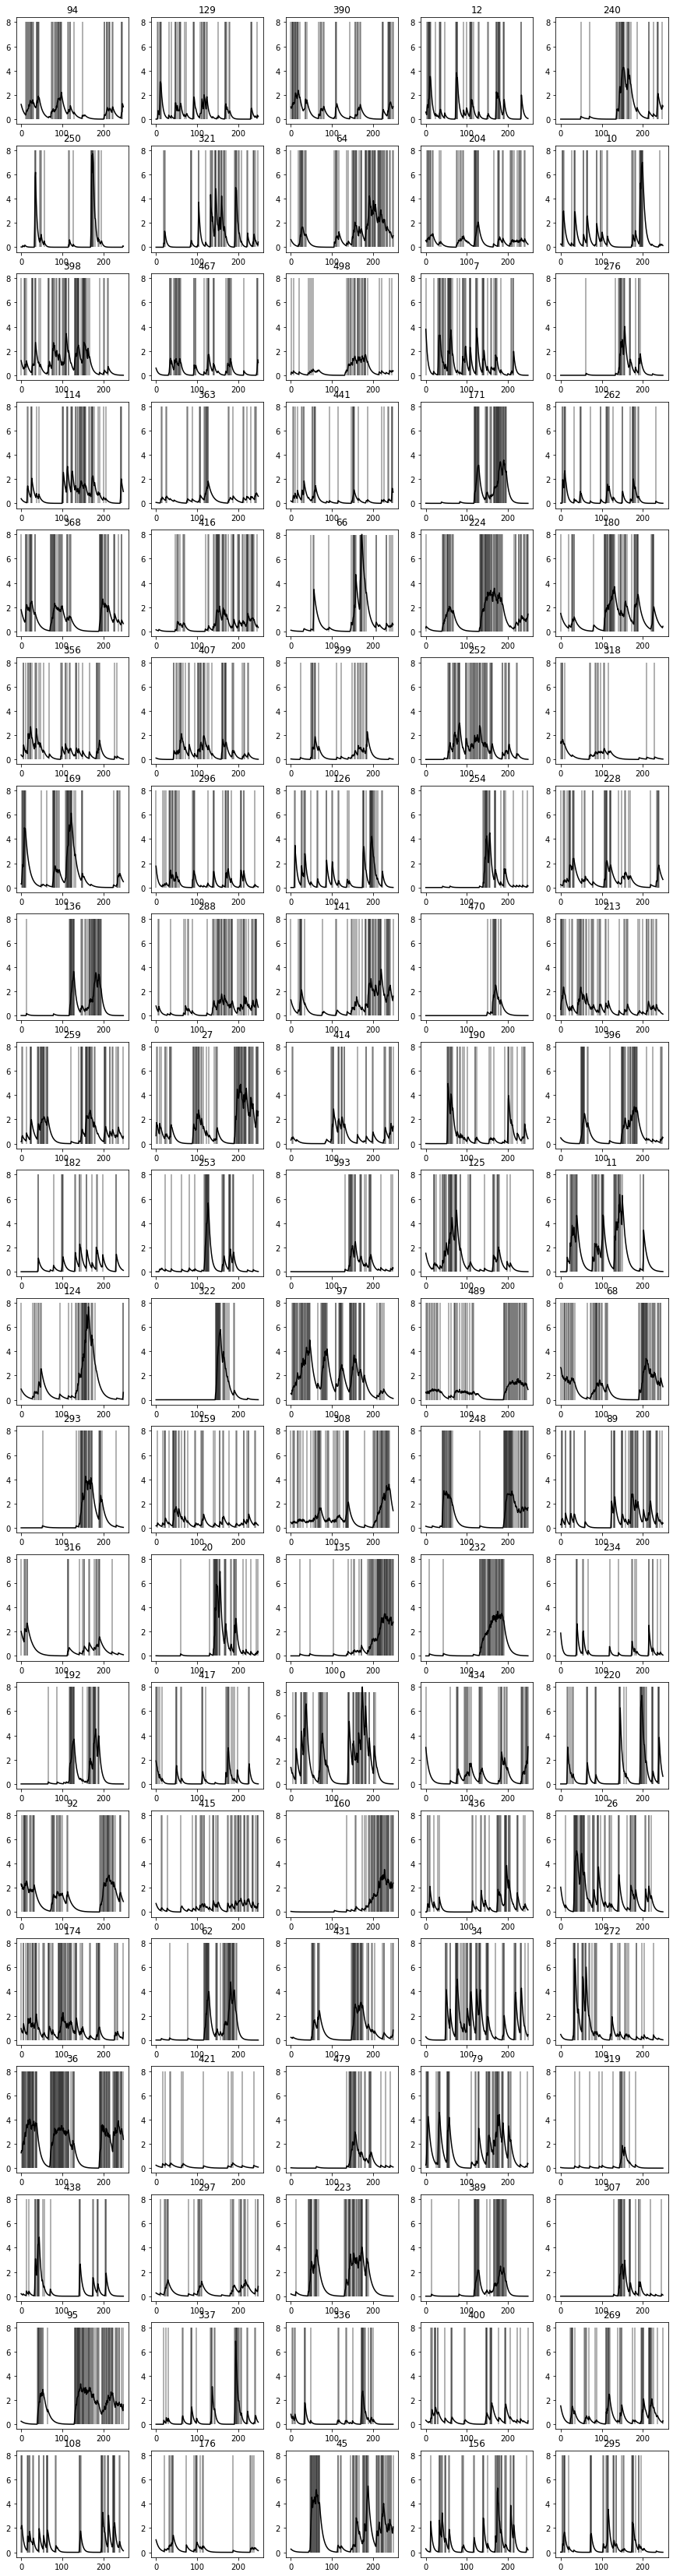

In [34]:
_, axes = plt.subplots(20, 5, figsize = (15, 60))
indexes = np.random.permutation(500)

for i, ax in enumerate(axes.flatten()):
    idx = np.argsort(np.sum(spikes, 1))[::-1][indexes[i]]#int(np.argmax(np.sum(spikes, 1)))
    df_sub = df[idx,500:750]
    peaks = np.where( (spikes[idx, 500:750] > 0.15) == 1)
    ax.plot(df_sub, 'k')
    ax.set_title(str(indexes[i]))
    ax.vlines(peaks, 0, 8, colors=(0, 0, 0, 0.4))

plt.show()

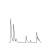

In [77]:
def sample_trace(idx=358, figsize=(0.5, 0.5)):#idx=[234, 358]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    idx = np.argsort(np.sum(spikes, 1))[::-1][idx]#int(np.argmax(np.sum(spikes, 1)))
    df_sub = df[idx,530:700]
    df_sub /= max(df_sub)
    peaks = np.where( (spikes[idx, 530:700] > 0.1) == 1)
    plt.plot(df_sub, 'k', linewidth=0.2)
    plt.ylim([-0.01, 1.51])
    #plt.vlines(peaks, 0, 1.51, colors=(0, 0, 0, 0.4), linewidth=0.2)
    plt.xticks([])
    plt.yticks([])

    return
sample_trace(idx=234)
#plt.savefig(r'C:\Users\sebas\RU\intern\Figures\Sample_trace0_fig2a.png', orientation = 'portrait', format = 'png', dpi=800)

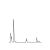

In [106]:
def sample_trace_after(idx0=358, idx1=234, p=0.4, figsize=(0.5, 0.5)):#idx=[234, 358]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    idx = np.argsort(np.sum(spikes, 1))[::-1][idx0]#int(np.argmax(np.sum(spikes, 1)))
    df_sub = df[idx,530:700]
    df_sub /= max(df_sub)

    idx = np.argsort(np.sum(spikes, 1))[::-1][idx1]#int(np.argmax(np.sum(spikes, 1)))
    df_sub1 = df[idx,530:700]
    df_sub1 /= max(df_sub1)

    df_sub = (p * df_sub + (1-p) * df_sub1) * df_sub
    
    df_sub[:51] = df_sub[:51]*0.4
    df_sub /= max(df_sub)

    peaks = np.where( (spikes[idx, 530:700] > 0.1) == 1)
    plt.plot(df_sub, 'k', linewidth=0.2)
    plt.ylim([-0.01, 1.51])
    #plt.vlines(peaks, 0, 1.51, colors=(0, 0, 0, 0.4), linewidth=0.2)
    plt.xticks([])
    plt.yticks([])

    return
sample_trace_after(idx0=234, idx1=358, p=0.3)
# sample_trace_after(idx0=358, idx1=234, p=0.3)
#plt.savefig(r'C:\Users\sebas\RU\intern\Figures\Sample_trace_after0_fig2a.png', orientation = 'portrait', format = 'png', dpi=800)


In [28]:
idx = np.argsort(np.sum(spikes, 1))[::-1][234]
idx1 = np.argsort(np.sum(spikes, 1))[::-1][358]
df_sub = df[idx,500:720]
df_sub1 = df[idx1,500:720]
peaks = np.where( (spikes[idx, 500:720] > 0.15) == 1)
peaks1 = np.where( (spikes[idx1, 500:720] > 0.15) == 1)

trace = [df_sub, df_sub1]
peaks = [peaks, peaks1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<AxesSubplot:xlabel='# Strong weights per neuron', ylabel='PDF'>

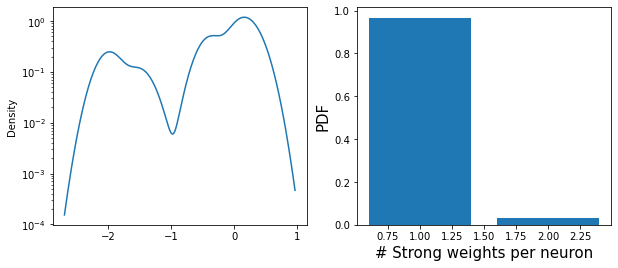

In [106]:
idx = np.argsort(np.sum(spikes, 1))[::-1][:10000]
idx[np.random.permutation(len(idx))[:500]]

NameError: name 'rbm' is not defined

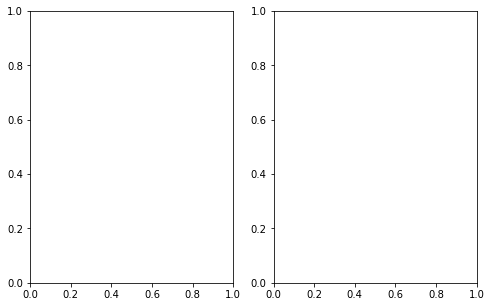

In [ ]:
np.argsort(np.sum(spikes, 1))

In [ ]:
# spikes[spikes <1] =0
# spikes[spikes >1] = 1
spikes = spikes[np.argsort(np.sum(spikes, 1))[::-1], :]
sns.heatmap(spikes[:1000, :])

In [ ]:
idx = np.argsort(np.sum(spikes, 1))[::-1][1]#int(np.argmax(np.sum(spikes, 1)))
df_sub = df[idx,1700:1950]
#peaks = np.where((df_sub[1:-1] > df_sub[0:-2]) * (df_sub[1:-1] > df_sub[2:]))[0] + 1
peaks = np.where( (spikes[idx, 1700:1950] > 0.15) == 1)
plt.plot(df_sub)
plt.ylim([-0.3, 8])
plt.vlines(peaks, -0.3, 8, 'k')

In [ ]:
np.mean(df[df!=0])

In [ ]:
peaks[235:250]

In [ ]:
np.argsort(np.sum(spikes, 1))[::-1][0]

In [ ]:
plot_reconstruction_error(rbm.errors, fs=12, title='Reconstruction error RBM')

Compare how well the RBM and RTRBM perform on first and second order statistics with regard to the data

In [ ]:
_, _, _, _ = infer_and_get_moments_plot(rtrbm=rbm, pre_gibbs_k=100, gibbs_k=100, mode=1, n=1000, m=50000)
_, _, _, _ = infer_and_get_moments_plot(rtrbm=rtrbm, pre_gibbs_k=100, gibbs_k=100, mode=1, n=1000, m=50000)

Structural comparisons of RBM and RTRBM with their receptive fields, and for the RTRBM also the temporal dependencies

In [ ]:
x_rtrbm = MapHiddenStructure(W=rtrbm.W, U=rtrbm.U)
ax = x_rtrbm.draw_final_structure()

Weights distributions and connectivity to hidden layer


In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_weights_log_distribution(rtrbm.W, ax=ax[0])
hist_strongest_weights(abs(rtrbm.W), threshold=0.5, ax=ax[1])


In [ ]:
_, ax = plt.subplots(1, 2, figsize=(8, 5))
rbm.U = torch.zeros(rbm.N_H, rbm.N_H)
x_rbm = MapHiddenStructure(W=rbm.W, U = rbm.U)
x_rtrbm = MapHiddenStructure(W=rtrbm.W, U=rtrbm.U)
ax[0] = x_rbm.draw_final_structure()
ax[1] = x_rtrbm.draw_final_structure()
plt.show()
